In [1]:
import os
import pickle
from ase.db import connect
from ase.visualize import view
import networkx as nx

from GAMERNet.rnet.networks.reaction_network import ReactionNetwork
from GAMERNet.rnet.networks.surface import Surface

with open('../scripts/c1pd111/rxn_net.pkl', 'rb') as pickle_file:
    content = pickle.load(pickle_file)  # dict of elementary reactions

rxn_net = ReactionNetwork().from_dict(content)
print(rxn_net)

ReactionNetwork(57 surface intermediates, 14 gas molecules, 105 elementary reactions)
Surface: Pd48(111)
Network Carbon cutoff: C1



# Try global reactions identifier

In [2]:
ngr = rxn_net.get_num_global_reactions(['10211g', '02011g'], ['14111g', '10111g', '02111g'])

Reactants: ['CO2', 'H2']
Products: ['CH4O', 'CO', 'H2O']
Number of chemical elements: 3
Number of chemical species: 5
Rank of the species-element matrix: 3
Number of global reactions: 2


In [3]:
ngr


2

# delete intermediates

In [ ]:
rxn_net.del_intermediates(["12411*"])
print(rxn_net)

# Visualization

In [2]:
rxn_net.visualize_intermediate('01011*')

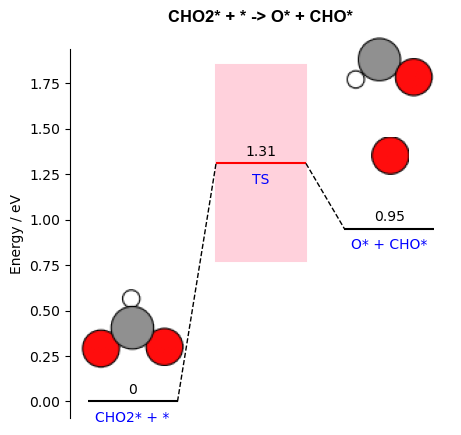

In [11]:
for rxn in rxn_net.reactions:
    rxn.calc_reaction_barrier(bep_params=[0.55, 0.8])    
rxn_net.visualize_reaction(55, show_uncertainty=True)

# Work with graph representation

In [ ]:
graph = rxn_net.gen_graph(show_steps=False, del_surf=True)
for node in graph.nodes:
    print(node, graph.nodes[node])

In [ ]:
rxn_net.write_dotgraph(".", "test_del.png", show_steps=False)

In [ ]:
rxn_net.write_dotgraph(".", 'HIGHLIGHT_test.png', del_surf=True,  show_steps=False, highlight=x)

# interactive plotly graph

In [ ]:
graph = rxn_net.gen_graph(del_surf=True, show_steps=False, highlight=x)

In [ ]:
import plotly.graph_objects as go

def gen_interactive_graph(graph: nx.DiGraph):
    pos = nx.kamada_kawai_layout(graph)
    nx.set_node_attributes(graph, pos, 'pos')
    edge_x = []
    edge_y = []
    G = graph
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
    
    node_x = [pos[0] for pos in list(nx.get_node_attributes(G,'pos').values())]
    node_y = [pos[1] for pos in list(nx.get_node_attributes(G,'pos').values())]
    
    hover_texts = []
    for node in G.nodes(data=True):
        img_path = node[1]['fig_path']
        formula = node[1]['formula']
        hover_text = f"""<
                <TABLE BORDER="0" CELLBORDER="0" CELLSPACING="0">
                <TR>
                <TD><IMG SRC="{img_path}"/></TD>
                </TR>
                <TR>
                <TD>{formula}</TD>
                </TR>
                </TABLE>>"""
        hover_texts.append(hover_text)
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        hovertext=hover_texts,
        marker=dict(
            showscale=True,
            size=30,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            )
        )
    )
    
    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append(f"# of connections: {len(adjacencies[1])}")
    
    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text
    
    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0,l=0,r=0,t=0),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False))
                    )
    fig.show()
    

In [ ]:
gen_interactive_graph(graph)

In [ ]:
import networkx as nx
from collections import deque

def constrained_shortest_path(graph, source, target, intermediates_to_avoid):
    visited = set()
    queue = deque([(source, [source])])  # Each element of the queue is a tuple (node, path_so_far)

    while queue:
        current_node, path_so_far = queue.popleft()

        if current_node == target:
            return path_so_far

        visited.add(current_node)

        for neighbor in graph.neighbors(current_node):
            # Skip nodes that are not elementary reactions
            if 'type' in graph.nodes[neighbor] and graph.nodes[neighbor]['type'] != 'elementary_reaction':
                continue

            # Skip intermediates to avoid
            if neighbor in intermediates_to_avoid:
                continue
            
            if neighbor not in visited:
                queue.append((neighbor, path_so_far + [neighbor]))
                visited.add(neighbor)
                
    return None  # return None if no such path exists


In [ ]:
import networkx as nx
from collections import deque

# Define your graph here
G = nx.Graph()
G.add_edges_from([
    ("A", "R1"),
    ("R1", "B"),
    ("B", "R2"),
    ("R2", "C"),
    ("B", "R3"),
    ("R3", "D"),
])

# Annotate nodes with their types
for node in ["A", "B", "C", "D"]:
    G.nodes[node]['type'] = 'intermediate'
for node in ["R1", "R2", "R3"]:
    G.nodes[node]['type'] = 'elementary_reaction'

def custom_shortest_path(rxn_net, graph, source, target):
    queue = deque([(source, [])])
    graph = graph.to_undirected()
    intermediates_visited = set()
    reactions_visited = set()
    while queue:
        current_node, path_so_far = queue.popleft()
        
        # Check if the target node is reached
        if current_node == target:
            return path_so_far

        intermediates_visited.add(current_node)

        for step in graph.neighbors(current_node):
            if step in reactions_visited:
                continue

            # Update the path based on the type of the neighbor
            inters = list(rxn_net.reactions[step].reactants) + list(rxn_net.reactions[step].products)
            unvisited_inters = [inter for inter in inters if inter not in intermediates_visited]
            if len(unvisited_inters) != 0:
                continue
            new_path = path_so_far + [step] if graph.nodes[step]['category'] not in ('ads', 'sur', 'gas') else path_so_far

            queue.append((step, new_path))
            visited.add(neighbor)

    return None  # Path not found

def custom_shortest_path(net, graph, source, target):
    visited = set()
    visited_inters = {'000000*', '010101*'}
    queue = deque([(source, [])])

    while queue:
        current_node, path_so_far = queue.popleft()
        
        # Check if the target node is reached
        if current_node == target:
            return path_so_far

        visited.add(current_node)
        if graph.nodes[current_node]['category'] in ('ads', 'sur', 'gas'):
            visited_inters.add(current_node)

        for neighbor in graph.neighbors(current_node):
            # Skip if already visited
            if neighbor in visited:
                continue

            if graph.nodes[neighbor]['category'] not in ('ads', 'sur', 'gas'):
                index = rxn_net.reactions[neighbor].index
                inters = list(net.reactions[index].reactants) + list(net.reactions[index].products)
                if not all([inter in visited_inters for inter in inters]):
                    continue

            # Update the path based on the type of the neighbor
            new_path = path_so_far + [neighbor] if graph.nodes[neighbor]['type'] == 'elementary_reaction' else path_so_far

            queue.append((neighbor, new_path))
            visited.add(neighbor)

    return None  # Path not found

def shortest_path_sm(graph, source, target):
    # select all nodes that are not intermediates
    visited_intermediates = set()
    rxn_nodes = [node for node in graph.nodes if graph.nodes[node]['category'] not in ('ads', 'sur', 'gas')]
    break_condition = lambda node: target in node
    cc_condition = lambda node: all([intermediate in visited_intermediates for intermediate in node])




In [ ]:
nx_graph = rxn_net.graph

In [ ]:
x = custom_shortest_path(rxn_net, nx_graph, '102101g', '141101g')
x

In [ ]:
rxn_net.reactions

# Other

In [ ]:
for inter in rxn_net.intermediates.values():
    if inter.closed_shell:
        print(inter.smiles)

In [ ]:
rxn_net.add_eley_rideal('101101g', '001101*', '102101*')
print(rxn_net)

In [ ]:
print(len(rxn_net.reactions))

In [ ]:
print(len(rxn_net.reactions))

In [ ]:
counter  =0 
for reaction in rxn_net.reactions:
    counter += 1
    print(counter, reaction.code, reaction.components, reaction.r_type)

In [ ]:
for reaction in rxn_net.reactions:
    print(reaction.components)
    for component in reaction.components:
        for inter in component:
            print(inter.code)

In [ ]:
print(len(rxn_net.intermediates))

In [ ]:
closed_shell_atoms = []
for inter in rxn_net.intermediates.values():
    if inter.closed_shell == True:
        closed_shell_atoms.append(inter.molecule)
print(len(closed_shell_atoms))

In [ ]:
closed_shell_atoms = []
for inter in rxn_net.intermediates.values():
    if inter.closed_shell == True:
        closed_shell_atoms.append(inter.molecule)
print(len(closed_shell_atoms))

In [ ]:
closed_shell_atoms[0].get_chemical_symbols().count("H")

In [ ]:
view(closed_shell_atoms)

In [ ]:
y = rxn_net.gen_graph()
# y.remove_node("")
for node in y.nodes(data=True):
    print(node)
print(y)

In [ ]:
rxn_net.surface.facet

In [ ]:
rxn_net.write_dotgraph(".", 'OLIV_test.png', del_surf=True)

Look for intermediates with specified composition

In [ ]:
rxn_net.search_inter_by_elements({'C':1, 'H':2, 'O':2})

Look for all elementary steps involving a specific intermediate

In [ ]:
rxn_net.search_ts(["222101"])

In [ ]:
types = []
for reaction in rxn_net.reactions:
    types.append(reaction.r_type)
print(set(types))

In [ ]:
types = []
for inter in rxn_net.intermediates.values():
    types.append(inter.phase)
print(set(types))

# Try PyEnergyDiagrams>

In [ ]:
import matplotlib.pyplot as plt
from energydiagram import ED
diagram = ED()
diagram.add_level(0,'Separated Reactants')
diagram.add_level(-5.4,'mlC1')
diagram.add_level(-15.6,'mlC2','last',) #Using 'last'  or 'l' it will be together with the previous level
diagram.add_level(28.5,'mTS1',color='g')
diagram.add_level(-9.7,'mCARB1')
diagram.add_level(-19.8,'mCARB2','l')
diagram.add_level(20,'mCARBX','last')

In [ ]:
def visualize_step(step):
    import re
    rxn = step.__repr__()
    components = rxn.split("<->")
    reactants = components[0].split("+")
    products = components[1].split("+")
    # keep only chars between parentheses
    reactants = [re.findall(r'\((.*?)\)', reactant) for reactant in reactants]
    products = [re.findall(r'\((.*?)\)', product) for product in products]
    # flatten list of lists
    reactants = [item for sublist in reactants for item in sublist]
    products = [item for sublist in products for item in sublist]
    rxn_string = " + ".join(reactants) + " -> " + " + ".join(products)
    diagram = ED()
    diagram.add_level(0, rxn_string.split(" -> ")[0])
    diagram.add_level(round(step.e_act[0], 2), 'TS', color='r')
    diagram.add_level(round(step.energy[0], 2), rxn_string.split(" -> ")[1])
    diagram.add_link(0,1)
    diagram.add_link(1,2)
    y = diagram.plot(ylabel="Energy / eV") # this is the default ylabel
    # add title in Arial and bold, shifted slightly above
    # the default position
    plt.title(rxn_string, fontname='Arial', fontweight='bold',
              y=1.05) 
    # from os import makedirs
    # from ase.io import write
    # from os.path import abspath
    # from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    # makedirs('tmp', exist_ok=True)
    # for inter in step.reactants:        
    #     fig_path = abspath("tmp/{}.png".format(inter.code))
    #     write(fig_path, inter.molecule, show_unit_cell=0)
    #     arr_img = plt.imread(fig_path)
    #     im = OffsetImage(arr_img)
    #     ab = AnnotationBbox(im, (1, 0), xycoords='axes fraction')
    #     diagram.ax.add_artist(ab)
    # diagram.plot(ylabel="eV")
    return diagram
        
    

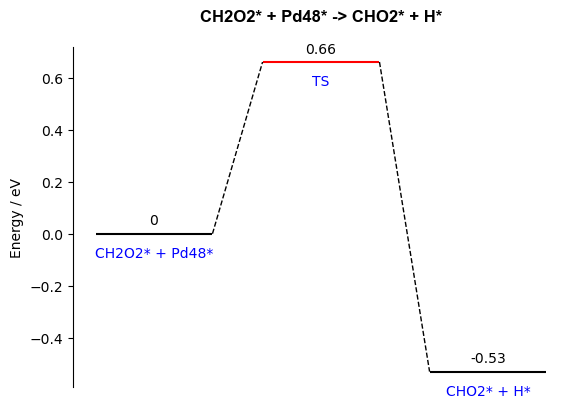

In [7]:
y = rxn_net.visualize_reaction(10)

In [9]:
y.fig.get_default_bbox_extra_artists()

[<Axes: title={'center': 'CH2O2* + Pd48* -> CHO2* + H*'}, ylabel='Energy / eV'>,
 Text(0.86649255, 0.023799999999999998, '0'),
 Text(1.0911387666666668, 0, ''),
 Text(0.6418463333333334, 0, ''),
 Text(0.86649255, -0.047599999999999996, 'CH2O2* + Pd48*'),
 Text(1.5083388833333335, 0.6838000000000001, '0.66'),
 Text(1.7329851, 0.66, ''),
 Text(1.2836926666666668, 0.66, ''),
 Text(1.5083388833333335, 0.6124, 'TS'),
 Text(2.150185216666667, -0.5062, '-0.53'),
 Text(2.3748314333333336, -0.53, ''),
 Text(1.9255390000000001, -0.53, ''),
 Text(2.150185216666667, -0.5776, 'CHO2* + H*'),

In [12]:
artists = y.fig.get_default_bbox_extra_artists()
type(artists[1])
# add rectangle to the y axis
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import numpy as np

# create a list of Rectangle patches
rectangles = []
for i in range(10):
    rectangles.append(Rectangle((0, i), 1, 1))



matplotlib.text.Text

In [18]:
artists = y.fig.get_default_bbox_extra_artists()
rect_width = artists[2].get_position()[0] - artists[3].get_position()[0]
std = 0.3
rect_height = 1.96*2*std
anchor_point1 = (min(artists[2].get_position()[0], artists[3].get_position()[0]), )
anchor_point2 = (min(artists[2].get_position()[0], artists[3].get_position()[0]), )
anchor_point3 = (min(artists[2].get_position()[0], artists[3].get_position()[0]), )

0.44929243333333335